
# VGGNet 

In [0]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as transforms
import torchvision.datasets as dsets 
import torchvision
import time
import os


In [0]:
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

train_dataset = dsets.CIFAR10(root='./data/CIFAR10/', 
                            train=True, 
                            transform=transform_train,
                            download=True)

test_dataset = dsets.CIFAR10(root='./data/CIFAR10/', 
                           train=False, 
                           transform=transform_test)

STEP 1: LOADING DATASET


Extracting ./data/CIFAR10/cifar-10-python.tar.gz to ./data/CIFAR10/


In [0]:
# reducing the dataset
reduced_train_dataset = []
for images, labels in train_dataset:
    if labels < 3:
        reduced_train_dataset.append((images, labels))
        
reduced_test_dataset = []
for images, labels in test_dataset:
    if labels < 3:
        reduced_test_dataset.append((images, labels))

In [0]:
print("The number of training images : ", len(reduced_train_dataset))
print("The number of test images : ", len(reduced_test_dataset))

The number of training images :  15000
The number of test images :  3000


In [0]:
print('STEP 2: MAKING DATASET ITERABLE')

train_loader = torch.utils.data.DataLoader(dataset=reduced_train_dataset, 
                                           batch_size=128, 
                                           shuffle=True)

test_loader = torch.utils.data.DataLoader(dataset=reduced_test_dataset, 
                                          batch_size=100, 
                                          shuffle=False)

class_names = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

STEP 2: MAKING DATASET ITERABLE


### Visualize a few images

In [0]:
import matplotlib.pyplot as plt
%matplotlib inline  
import numpy as np

In [0]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.4914, 0.4822, 0.4465])
    std = np.array([0.2023, 0.1994, 0.2010])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated

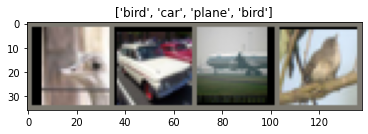

In [0]:
train_loader_sample = torch.utils.data.DataLoader(dataset=reduced_train_dataset, 
                                           batch_size=4, 
                                           shuffle=True)

# Get a batch of training data
inputs, classes = next(iter(train_loader_sample))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [0]:
class VGG(nn.Module):
    def __init__(self):
        super(VGG, self).__init__()

        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv3 = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv4 = nn.Sequential(
            nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv5 = nn.Sequential(
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.fc1 = nn.Linear(512, 3)

    def forward(self, x):
        # Convolutions
        out = self.conv1(x)
        out = self.conv2(out)
        out = self.conv3(out)
        out = self.conv4(out)
        out = self.conv5(out)
        
        # Resize
        out = out.view(out.size(0), -1)
        out = self.fc1(out)

        return out


STEP 3: CREATE MODEL CLASS (VGG16)


In [0]:
## Instantiate Model Class

model = VGG()
num_total_params = sum(p.numel() for p in model.parameters())
print("The number of parameters : ", num_total_params)


device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)

STEP 4: INSTANTIATE MODEL CLASS
The number of parameters :  14724675


VGG(
  (conv1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv3): Sequential(
    (0): Conv2d(128, 256, 

In [0]:
## Loss/Optimizer

criterion = nn.CrossEntropyLoss()
learning_rate = 1e-2
momentum = 0.9
weight_decay = 5e-4

optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum = momentum, weight_decay = weight_decay)

STEP 5: INSTANTIATE LOSS CLASS
STEP 6: INSTANTIATE OPTIMIZER CLASS


In [0]:
## Training
num_epochs = 20

iter = 0
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):

        images = images.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()

        optimizer.step()
        
    correct = 0
    total = 0
    # Iterate through test dataset
    for images, labels in test_loader:

        images = images.to(device)
        labels = labels.to(device)
        
        outputs = model(images) 
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum()

    accuracy = 100 * correct.item() / total

    # Print Loss
    print('Epoch {}. Loss: {}. Accuracy: {}'.format(epoch, loss.item(), accuracy))
#############

STEP 7: TRAIN THE MODEL
Epoch 0. Loss: 0.42976441979408264. Accuracy: 68.43333333333334
Epoch 1. Loss: 0.3990030586719513. Accuracy: 84.6
Epoch 2. Loss: 0.2811725437641144. Accuracy: 89.2
Epoch 3. Loss: 0.18449890613555908. Accuracy: 89.86666666666666
Epoch 4. Loss: 0.07158243656158447. Accuracy: 89.23333333333333
Epoch 5. Loss: 0.5676718354225159. Accuracy: 90.0
Epoch 6. Loss: 0.05524587631225586. Accuracy: 90.23333333333333
Epoch 7. Loss: 0.1432066559791565. Accuracy: 90.8
Epoch 8. Loss: 0.08939076215028763. Accuracy: 91.43333333333334
Epoch 9. Loss: 0.020894551649689674. Accuracy: 92.43333333333334
Epoch 10. Loss: 0.29901203513145447. Accuracy: 92.13333333333334
Epoch 11. Loss: 0.11552149057388306. Accuracy: 91.73333333333333
Epoch 12. Loss: 0.019544055685400963. Accuracy: 91.76666666666667
Epoch 13. Loss: 0.023587286472320557. Accuracy: 91.53333333333333
Epoch 14. Loss: 0.0008504788274876773. Accuracy: 91.5
Epoch 15. Loss: 0.14940392971038818. Accuracy: 92.53333333333333
Epoch 16. 